In [1]:
import numpy as np
import pandas as pd
import csv
import random
import time
import matplotlib.pyplot as plt
import requests, zipfile
import codecs
from datetime import date, datetime
from io import BytesIO
from bs4 import BeautifulSoup
from unidecode import unidecode

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
url_file = "http://www1.caixa.gov.br/loterias/_arquivos/loterias/D_lotfac.zip"
req = requests.get(url_file, stream=True)

with zipfile.ZipFile(BytesIO(req.content), "r") as zip_file:
    zip_file.extractall()

In [4]:
with open("d_lotfac.htm", "r", encoding = "ISO-8859-1") as html_file:
    soup = BeautifulSoup(html_file, "lxml", from_encoding="utf-8")

In [5]:
# page = codecs.open("d_lotfac.htm", "r", encoding = "ISO-8859-1")
# soup = BeautifulSoup(page.read(), "lxml")
table = soup.find_all("table")[0]
# table
rows = table.find_all('tr')

In [6]:
data = []

for row in rows[1:]:
    cols = row.find_all('td')
    cols = [x.text.strip() for x in cols]
    data.append([x for x in cols if x])
    
# data

# for row in rows[:1]:
#     col_names = row.find_all('th')
#     col_names = [unidecode(name.text.strip().lower()) for name in col_names]

# col_names.remove('cidade')
# col_names

In [7]:
data_clean = []

for d in data:
    if len(d) == 32:
        data_clean.append(d)
    elif len(d) == 33:
        del d[19]
        data_clean.append(d)

# data_clean

In [8]:
lotofacil_df = pd.DataFrame(data_clean)
lotofacil_df = lotofacil_df.drop([17, 19, 29, 30, 31], axis=1)

In [9]:
col_names = ['concurso', 'data_sorteio', 'bola_1', 'bola_2', 'bola_3', 'bola_4', 'bola_5', 'bola_6', 'bola_7', 'bola_8', 'bola_9', 'bola_10', 'bola_11', 'bola_12', 'bola_13', 'bola_14', 'bola_15', 'ganhadores_15', 'ganhadores_14', 'ganhadores_13', 'ganhadores_12', 'ganhadores_11', 'valor_15', 'valor_14', 'valor_13', 'valor_12', 'valor_11']
lotofacil_df.columns = col_names
# df

In [10]:
lotofacil_df['data_sorteio'] = pd.to_datetime(lotofacil_df['data_sorteio'], format="%d/%m/%Y")
# df.head()

In [11]:
lotofacil_df[['valor_15', 'valor_14', 'valor_13', 'valor_12', 'valor_11']] = lotofacil_df[['valor_15', 'valor_14', 'valor_13', 'valor_12', 'valor_11']].apply(lambda x: x.str.replace('.','').str.replace(',', '.'))
# df.head()

In [12]:
lotofacil_df[['bola_1', 'bola_2', 'bola_3', 'bola_4', 'bola_5', 'bola_6', 'bola_7', 'bola_8', 'bola_9', 'bola_10', 'bola_11', 'bola_12', 'bola_13', 'bola_14', 'bola_15', 'ganhadores_15', 'ganhadores_14', 'ganhadores_13', 'ganhadores_12', 'ganhadores_11']] = lotofacil_df[['bola_1', 'bola_2', 'bola_3', 'bola_4', 'bola_5', 'bola_6', 'bola_7', 'bola_8', 'bola_9', 'bola_10', 'bola_11', 'bola_12', 'bola_13', 'bola_14', 'bola_15', 'ganhadores_15', 'ganhadores_14', 'ganhadores_13', 'ganhadores_12', 'ganhadores_11']].astype(int)

lotofacil_df[['valor_15', 'valor_14', 'valor_13', 'valor_12', 'valor_11']] = lotofacil_df[['valor_15', 'valor_14', 'valor_13', 'valor_12', 'valor_11']].astype(float)

In [13]:
lotofacil_df.head()

,concurso,data_sorteio,bola_1,bola_2,bola_3,bola_4,bola_5,bola_6,bola_7,bola_8,bola_9,bola_10,bola_11,bola_12,bola_13,bola_14,bola_15,ganhadores_15,ganhadores_14,ganhadores_13,ganhadores_12,ganhadores_11,valor_15,valor_14,valor_13,valor_12,valor_11
0,1,2003-09-29,18,20,25,23,10,11,24,14,6,2,13,9,5,16,3,5,154,4645,48807,257593,49765.82,689.84,10.0,4.0,2.0
1,2,2003-10-06,23,15,5,4,12,16,20,6,11,19,24,1,9,13,7,1,184,6232,81252,478188,596323.70,1388.95,10.0,4.0,2.0
2,3,2003-10-13,20,23,12,8,6,1,7,11,14,4,16,10,9,17,24,2,158,6897,96244,608211,400623.70,2173.36,10.0,4.0,2.0
3,4,2003-10-20,16,5,25,24,23,8,12,2,17,18,1,10,4,19,13,1,258,9569,123912,706657,902226.02,1498.72,10.0,4.0,2.0
4,5,2003-10-27,15,13,20,2,11,24,9,16,4,23,25,12,8,19,1,2,472,14736,195636,860992,380017.55,687.49,10.0,4.0,2.0


# K-Means

In [14]:
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_completeness_v_measure

In [15]:
numeros = [sorted(x) for x in lotofacil_df.iloc[:, 2:17].values]
num_array = np.asarray(numeros)
# numeros_df = pd.DataFrame(numeros)

In [16]:
hpc = PCA(n_components = 2).fit_transform(num_array)

In [36]:
# Determinando um range de K
k_range = range(1,15)

In [37]:
# Aplicando o modelo K-Means a cada valor de K
k_means_var = [KMeans(n_clusters = k).fit(hpc) for k in k_range]

In [28]:
# Ajustando o centróide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

In [29]:
# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(hpc, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

In [71]:
# Soma dos quadrados das distâncias dentro do cluster
wcss = [sum(d**2) for d in dist]
print(wcss)

[71464.51242407506, 43124.3178427599, 35260.81949702026, 31307.435607206087, 28266.109932365784, 26357.49717759485, 24766.483555460312, 23774.949383127485, 22819.036697213225, 22112.531058210814, 21431.61131735806, 20871.55917964248, 20375.309844589025, 19962.89193748911]


In [72]:
# Soma total dos quadrados
tss = sum(pdist(hpc)**2)/hpc.shape[0]
print(tss)

54620.590168388684


In [73]:
# Soma dos quadrados entre clusters
bss = tss - wcss
print(bss)

[-16843.92225569  11496.27232563  19359.77067137  23313.15456118
  26354.48023602  28263.09299079  29854.10661293  30845.64078526
  31801.55347118  32508.05911018  33188.97885103  33749.03098875
  34245.2803238   34657.6982309 ]


Text(0.5,1,'Variância Explicada x Valor de K')

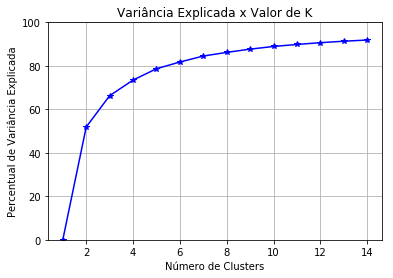

In [33]:
# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('Percentual de Variância Explicada')
plt.title('Variância Explicada x Valor de K')

In [55]:
km = KMeans(n_clusters = 4)
km.fit(hpc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [56]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = hpc[:, 0].min(), hpc[:, 0].max()
y_min, y_max = hpc[:, 1].min(), hpc[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = km.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

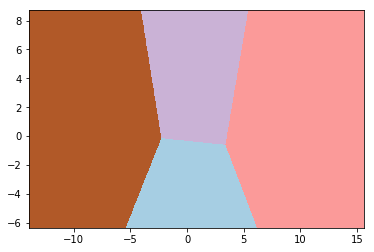

In [57]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()), 
           cmap = plt.cm.Paired, 
           aspect = 'auto', 
           origin = 'lower')

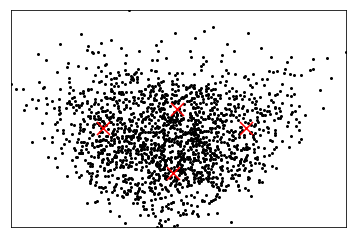

In [58]:
# Plot dos centróides de cada cluster
plt.plot(hpc[:, 0], hpc[:, 1], 'k.', markersize = 4)
centroids = km.cluster_centers_
inert = km.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
# Determinando um range de K
k_range = range(1,15)

In [43]:
# Aplicando o modelo K-Means a cada valor de K
k_means_var = [KMeans(n_clusters = k).fit(num_array) for k in k_range]

In [44]:
# Ajustando o centróide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

In [46]:
# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(num_array, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

In [47]:
# Soma dos quadrados das distâncias dentro do cluster
wcss = [sum(d**2) for d in dist]

In [49]:
# Soma total dos quadrados
tss = sum(pdist(num_array)**2)/num_array.shape[0]

In [50]:
# Soma dos quadrados entre clusters
bss = tss - wcss

Text(0.5,1,'Variância Explicada x Valor de K')

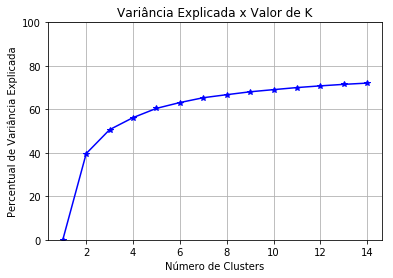

In [51]:
# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('Percentual de Variância Explicada')
plt.title('Variância Explicada x Valor de K')

In [59]:
km = KMeans(n_clusters = 3)
km.fit(num_array)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [65]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = num_array[:, 0].min(), num_array[:, 0].max()
y_min, y_max = num_array[:, 1].min(), num_array[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = km.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ValueError: Incorrect number of features. Got 2 features, expected 15

In [ ]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()), 
           cmap = plt.cm.Paired, 
           aspect = 'auto', 
           origin = 'lower')

In [ ]:
# Plot dos centróides de cada cluster
plt.plot(hpc[:, 0], hpc[:, 1], 'k.', markersize = 4)
centroids = km.cluster_centers_
inert = km.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## diferenca cluster de acordo com K

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from src.metricas import calculate_wcss, optimal_number_of_clusters

In [ ]:
# preparando nossos dados
# iris = sns.load_dataset('iris')
# df = iris.drop('species', axis=1)

In [74]:
# calculando a soma dos quadrados para as 19 quantidade de clusters
sum_of_squares = calculate_wcss(hpc)

# calculando a quantidade ótima de clusters
n = optimal_number_of_clusters(sum_of_squares)

# inicializando o kmeans para nossa quantidade ótima de clusters
kmeans = KMeans(n_clusters=n)

# predizendo nossos clusters
lotofacil_df['clusters'] = kmeans.fit_predict(num_array)

# transformando as especies de iris em numeros para colorir o gráfico
# iris['species_encoded'] = LabelEncoder().fit_transform(iris['species'])

2


In [77]:
lotofacil_df.head()

,concurso,data_sorteio,bola_1,bola_2,bola_3,bola_4,bola_5,bola_6,bola_7,bola_8,bola_9,bola_10,bola_11,bola_12,bola_13,bola_14,bola_15,ganhadores_15,ganhadores_14,ganhadores_13,ganhadores_12,ganhadores_11,valor_15,valor_14,valor_13,valor_12,valor_11,clusters
0,1,2003-09-29,18,20,25,23,10,11,24,14,6,2,13,9,5,16,3,5,154,4645,48807,257593,49765.82,689.84,10.0,4.0,2.0,1
1,2,2003-10-06,23,15,5,4,12,16,20,6,11,19,24,1,9,13,7,1,184,6232,81252,478188,596323.70,1388.95,10.0,4.0,2.0,0
2,3,2003-10-13,20,23,12,8,6,1,7,11,14,4,16,10,9,17,24,2,158,6897,96244,608211,400623.70,2173.36,10.0,4.0,2.0,0
3,4,2003-10-20,16,5,25,24,23,8,12,2,17,18,1,10,4,19,13,1,258,9569,123912,706657,902226.02,1498.72,10.0,4.0,2.0,1
4,5,2003-10-27,15,13,20,2,11,24,9,16,4,23,25,12,8,19,1,2,472,14736,195636,860992,380017.55,687.49,10.0,4.0,2.0,1


In [ ]:
df.head()

In [ ]:
import pandas as pd
import pandas_profiling as pp
import numpy as np

In [ ]:
pp.ProfileReport(numeros_df)

In [ ]:
class Lotofacil:
    def __init__(self):
        self.id = 0
        self.data_sorteio = None
        self.ganhadores_15_numeros = 0
        self.valor_rateio_15_numeros = 0
        self.valor_rateio_14_numeros = 0
        self.valor_rateio_13_numeros = 0
        self.valor_rateio_12_numeros = 0
        self.valor_rateio_11_numeros = 0
        self.numeros = ()
        self.par = 0
        self.impar = 0
        self.sequencia = ()
        self.vertical = ()
        self.horizontal = ()
        
    def set_numeros(self, numeros):
        self.numeros = tuple(numeros)
        self.setParImpar()
        self.set_sequencia()
        self.set_horizontal()
        self.set_vertical()
        
    def set_sequencia(self):
        sequencia = []
        count = []

        sequencia.append(self.numeros[0])
        
        for i in np.arange(1, len(self.numeros)):
            if (self.numeros[i] - self.numeros[i-1] == 1):
                sequencia.append(self.numeros[i])
                
                if (i < len(self.numeros) - 1):
                    continue
                
            if (len(sequencia) > 1):
                count.append(len(sequencia))

            sequencia = []
            sequencia.append(self.numeros[i])
            
        self.sequencia = tuple(count)
        
    def setParImpar(self):
        self.par = sum([1 if x % 2 == 0 else 0 for x in self.numeros])
        self.impar = len(self.numeros) - self.par
        
    def set_horizontal(self):
        quantidade = []
        horizontal = np.arange(1,26)
        horizontal = np.reshape(horizontal, (5,5))
        
        for h in horizontal:
            quantidade.append(len(set(h).intersection(self.numeros)))
            
        self.horizontal = tuple(quantidade)
        
    def set_vertical(self):
        quantidade = []
        vertical = np.arange(1,26)
        vertical = np.reshape(vertical, (5,5)).transpose()
        
        for v in vertical:
            quantidade.append(len(set(v).intersection(self.numeros)))
            
        self.vertical = tuple(quantidade)
        

In [ ]:
class Jogo:
    def __init__(self):
        self.id = None
        self.data_cadastro = None
        self.quantidade = 0
        self.numeros = ()
        self.par = 0
        self.impar = 0
        self.sequencia = ()
        self.vertical = ()
        self.horizontal = ()
        
#     def sorteio(self, qtdNumeros = 15):
#         self.numeros = sorted(tuple(np.random.choice(np.arange(1, 26), qtdNumeros, replace= False)))
#         self.setQuantidade()
#         self.setParImpar()
        
#     def setQuantidade(self):
#         self.quantidade = len(self.numeros)

    def set_numeros(self, numeros):
        self.numeros = tuple(numeros)
        self.setParImpar()
        self.set_sequencia()
        self.set_horizontal()
        self.set_vertical()
        
    def setParImpar(self):
        self.par = sum([1 if x % 2 == 0 else 0 for x in self.numeros])
        self.impar = len(self.numeros) - self.par
        
    def set_sequencia(self):
        sequencia = []
        count = []

        sequencia.append(self.numeros[0])
        
        for i in np.arange(1, len(self.numeros)):
            if (self.numeros[i] - self.numeros[i-1] == 1):
                sequencia.append(self.numeros[i])
                
                if (i < len(self.numeros) - 1):
                    continue
                
            if (len(sequencia) > 1):
                count.append(len(sequencia))

            sequencia = []
            sequencia.append(self.numeros[i])
            
        self.sequencia = tuple(count)
        
    def set_horizontal(self):
        quantidade = []
        horizontal = np.arange(1,26)
        horizontal = np.reshape(horizontal, (5,5))
        
        for h in horizontal:
            quantidade.append(len(set(h).intersection(self.numeros)))
            
        self.horizontal = tuple(quantidade)
        
    def set_vertical(self):
        quantidade = []
        vertical = np.arange(1,26)
        vertical = np.reshape(vertical, (5,5)).transpose()
        
        for v in vertical:
            quantidade.append(len(set(v).intersection(self.numeros)))
            
        self.vertical = tuple(quantidade)

In [ ]:
def get_concursos_lotofacil_csv(arquivo):
    concursos = []
    
    with open(arquivo) as file:
        lotofacil = csv.reader(file, delimiter=';')
        data = list(lotofacil)
    
    for x in data[1:]:
        concurso = Lotofacil()
        concurso.id = int(x[0])
        concurso.data_sorteio = x[1]
        concurso.set_numeros(sorted(tuple(map(int, x[2:17]))))
#         concurso.numeros = sorted(tuple(map(int, x[2:17])))
        concurso.ganhadores_15_numeros = int(x[17])
        concurso.valor_rateio_15_numeros = float(x[22].replace('.', '').replace(',', '.'))
        concurso.valor_rateio_14_numeros = float(x[23].replace('.', '').replace(',', '.'))
        concurso.valor_rateio_13_numeros = float(x[24].replace('.', '').replace(',', '.'))
        concurso.valor_rateio_12_numeros = float(x[25].replace('.', '').replace(',', '.'))
        concurso.valor_rateio_11_numeros = float(x[26].replace('.', '').replace(',', '.'))
#         concurso.setParImpar()
        concursos.append(concurso)
    
    return tuple(concursos)

In [ ]:
def gerar_jogos(numero_jogos = 1000, numeros_por_jogo = 15, menor_numero = (), maior_numero = ()):
    count = 0
    jogos = []
    tentativas = 0
    
    try:
    
        while (len(jogos) < numero_jogos and tentativas < 100):
            add = False
            jogo = Jogo()
            jogo.sorteio(numeros_por_jogo)

            if (jogo.numeros[0] not in menor_numero or jogo.numeros[-1] not in maior_numero):
                tentativas += 1
                continue

            for i in jogos:
                if (len(i.numeros) == len(jogo.numeros)):
                    if (len(set(i.numeros).intersection(jogo.numeros)) == len(jogo.numeros)):
                        tentativas += 1
                        break

            jogos.append(jogo)
            count += 1
            tentativas = 0
            
        return tuple(jogos)
            
    except Exception as ex:
        return ex

In [ ]:
def filtrar_concursos_range(concursos, inicial, final):
    concursos_filtrados = []
    
    for c in concursos:
        if (c.id >= inicial and c.id <= final):
            concursos_filtrados.append(c)
    
    return concursos_filtrados

In [ ]:
# def filtrar_ultimos_concursos(concursos, ultimos):
#     concursos_filtrados = []
    
#     if (ultimos is not None):
#         concursos_filtrados = concursos[len(concursos)-ultimos:]
        
#     return concursos_filtrados

In [ ]:
def filtrar_concurso_por_numeros(concursos, numeros):
    concursos_filtrados = []
    
    for c in concursos:
        if (len(set(c.numeros).intersection(numeros)) == len(numeros)):
            concursos_filtrados.append(c)
#         if len(set(apostas[i].numeros).intersection(notin[j])) == len(notin[j]):
    
    return concursos_filtrados

In [ ]:
def imprimir_concursos(concursos):
    print("Total concursos: %s \n" % (len(concursos)))
    for c in concursos:
        print("Concurso: ", c.id)
        print("Data Sorteio: ", c.data_sorteio)
        print("Ganhadores 15 pontos: %s " % (c.ganhadores_15_numeros))
        print("Impares/Pares: %s/%s" % (c.impar, c.par))
#         print("Pares: %s" % (c.par))
        print("Sequencia: ", c.sequencia)
        print("Horizontal: ", c.horizontal)
        print("Vertical: ", c.vertical)
        print(c.numeros)
        print("\n")

In [ ]:
def imprimir_aposta(apostas):
    print("Total apostas: %s \n" % (len(apostas)))
    for a in apostas:
#         print("ID: ", a.id)
#         print("Data: ", a.data_sorteio)
        print("Impares: %s - Pares: %s" % (a.impar, a.par))
        print(a.numeros)
        print("\n")

In [ ]:
def imprimir_jogo(jogos):
    print("Total jogos: %s \n" % (len(jogos)))
    for a in jogos:
        print("ID: ", a.id)
#         print("Data Cadastro: ", a.data_cadastro)
        print("Tamanho: %s | Imapres/Pares: %s/%s | Max Sequencia: %s" % (len(a.numeros), a.impar, a.par, max(a.sequencia)))
        print(a.numeros)
        print("\n")

In [ ]:
def filtrar_jogo_menor_maior(jogos, menor = (), maior = ()):
    apostas_filtradas = []
    
    if (type(menor) != tuple):
        menor = tuple(menor)

    for jogo in jogos:
        if (jogo.numeros[0] in menor and jogo.numeros[-1] in maior):
            apostas_filtradas.append(jogo)
        
    return tuple(apostas_filtradas)

In [ ]:
def filtrar_jogo_impar_par(jogos, impar = ()):
    apostas_filtradas = []
    
    for jogo in jogos:
        for i in impar:
            if (jogo.impar == i):
                apostas_filtradas.append(jogo)
        
    return tuple(apostas_filtradas)

In [ ]:
def filtrar_jogo_por_numeros(jogos, numeros, match):
    apostas_filtradas = []
    
    for j in jogos:
        if (len(set(j.numeros).intersection(numeros)) >= match):
            apostas_filtradas.append(j)
        
    return apostas_filtradas

In [ ]:
# def filtrar_jogo_sequencia(jogos, sequencia = ()):
#     apostas_filtradas = []
#     add = True
    
#     for jogo in jogos:
#         for s in sequencia:
#             if (len(set(jogo.numeros).intersection(s)) == len(s)):
#                 add = False
#                 break
                
#         if (add):
#             apostas_filtradas.append(jogo)
        
#     return tuple(apostas_filtradas)

In [ ]:
def filtrar_jogo_sequencia(jogos, sequencia = ()):
    apostas_filtradas = []
    
    for jogo in jogos:
        if (len(set(jogo.numeros).intersection(sequencia)) == len(s)):
            apostas_filtradas.append(jogo)
        
    return tuple(apostas_filtradas)

In [ ]:
def filtrar_jogo_notin(jogos, numeros):
    apostas_filtradas = []
    
    for j in jogos:
        if (len(set(j.numeros).intersection(numeros)) == 0):
            apostas_filtradas.append(j)
        
    return apostas_filtradas

In [ ]:
def selecionar_jogos_aposta(jogos, quantidade):
    jogos_sample = random.sample(jogos, quantidade)
    menor_1 = 0
    menor_2 = 0
    menor_3 = 0
    impar_7 = 0
    impar_8 = 0
    impar_9 = 0
    seq_3 = 0
    seq_4 = 0
    seq_5 = 0
    seq_6 = 0
    seq_7 = 0

    for a in jogos_sample:
#         print(a.numeros, a.impar, a.par, a.numeros[0], a.numeros[-1])
        if a.numeros[0] == 1:
            menor_1 += 1
        elif a.numeros[0] == 2:
            menor_2 += 1
        elif a.numeros[0] == 3:
            menor_3 += 1

        if a.impar == 7:
            impar_7 += 1
        elif a.impar == 8:
            impar_8 += 1
        elif a.impar == 9:
            impar_9 += 1
            
        if max(a.sequencia) == 3:
            seq_3 += 1
        elif max(a.sequencia) == 4:
            seq_4 += 1
        elif max(a.sequencia) == 5:
            seq_5 += 1
        elif max(a.sequencia) == 6:
            seq_6 += 1
        elif max(a.sequencia) == 7:
            seq_7 += 1

    print('Percentual jogos com 1: ', (menor_1/len(jogos_sample))*100)
    print('Percentual jogos com 2: ', (menor_2/len(jogos_sample))*100)
    print('Percentual jogos com 3: ', (menor_3/len(jogos_sample))*100)
    print('Percentual jogos impar 7: ', (impar_7/len(jogos_sample))*100)
    print('Percentual jogos impar 8: ', (impar_8/len(jogos_sample))*100)
    print('Percentual jogos impar 9: ', (impar_9/len(jogos_sample))*100)
    print('Sequencia 3: ', (seq_3/len(jogos_sample))*100)
    print('Sequencia 4: ', (seq_4/len(jogos_sample))*100)
    print('Sequencia 5: ', (seq_5/len(jogos_sample))*100)
    print('Sequencia 6: ', (seq_6/len(jogos_sample))*100)
    print('Sequencia 7: ', (seq_7/len(jogos_sample))*100)

    return jogos_sample

In [ ]:
def conexao_mysql():
    return mysql.connector.connect(user='root', database='lotofacil', host='192.168.56.100', password='Zaq1@wsX')

In [ ]:
def get_numeros_jogo(jogo_id):
    numeros = []
    
    try:
        cnx = conexao_mysql()
        cursor = cnx.cursor()

        query = ("SELECT numero FROM numero_jogo "
                 "WHERE jogo_id = %(jogo_id)s "
                 "ORDER BY numero")
        
        param_query = {
            'jogo_id' : jogo_id,
        }
 
        cursor.execute(query, param_query)

        rows = cursor.fetchall()
        
        for row in rows:
            numeros.append(row[0])

    except Exception as ex:
        print(ex)
 
    except ConnectionError as e:
        print(e)
 
    finally:
        cursor.close()
        cnx.close()

    return tuple(numeros)

In [ ]:
# def get_numeros_jogo(jogo_id, numeros =()):
#     numeros = []
    
#     try:
#         cnx = conexao_mysql()
#         cursor = cnx.cursor()

#         query = ("SELECT numero FROM numero_jogo "
#                  "WHERE jogo_id = %(jogo_id)s "
#                  "AND numero in %(numeros)s "
#                  "ORDER BY numero")
        
#         param_query = {
#             'jogo_id' : jogo_id,
#         }
 
#         cursor.execute(query, param_query)

#         rows = cursor.fetchall()
        
#         for row in rows:
#             numeros.append(row[0])

#     except Exception as ex:
#         print(ex)
 
#     except ConnectionError as e:
#         print(e)
 
#     finally:
#         cursor.close()
#         cnx.close()

#     return tuple(numeros)

In [ ]:
def get_all_jogos():
    jogos = []
    cursor = None
    cnx = None
    
    try:
        cnx = conexao_mysql()
        cursor = cnx.cursor()

        query = ("SELECT jogo_id, data_cadastro "
                 "FROM jogo "
#                  "WHERE jogo_id < 10001 "
                 "ORDER BY jogo_id")
        
        cursor.execute(query)
        
        rows = cursor.fetchall()
        
        for row in rows:
            jogo = Jogo()
            jogo.id = row[0]
            jogo.data_cadastro = row[1]
            jogo.numeros = get_numeros_jogo(row[0])
            jogo.setParImpar()
            jogo.setQuantidade()
            jogos.append(jogo)
    #         print(jogo_id, data_cadastro)

    except Exception as ex:
        print(ex)
        
    except ConnectionError as e:
        print(e)
        
    finally:
        cursor.close()
        cnx.close()
    
    return jogos

In [ ]:
# def get_jogos(numeros = ()):
#     jogos = []
#     cursor = None
#     cnx = None
    
#     try:
#         cnx = conexao_mysql()
#         cursor = cnx.cursor()

#         query = ("SELECT jogo_id, data_cadastro "
#                  "FROM jogo "
# #                  "WHERE jogo_id < 10001 "
#                  "ORDER BY jogo_id")
        
#         cursor.execute(query)
        
#         rows = cursor.fetchall()
        
#         for row in rows:
#             jogo = Jogo()
#             jogo.id = row[0]
#             jogo.data_cadastro = row[1]
#             jogo.numeros = get_numeros_jogo(row[0])
#             jogo.setParImpar()
#             jogo.setQuantidade()
#             jogos.append(jogo)
#     #         print(jogo_id, data_cadastro)

#     except Exception as ex:
#         print(ex)
        
#     except ConnectionError as e:
#         print(e)
        
#     finally:
#         cursor.close()
#         cnx.close()
    
#     return jogos

In [ ]:
def insert_jogo(jogo):
    try:
        cnx = conexao_mysql()
        cursor = cnx.cursor()
       
        add_jogo = ("INSERT INTO jogo "
                     "(data_cadastro) "
                     "VALUES (%(data_cadastro)s)")
        add_numero_jogo = ("INSERT INTO numero_jogo "
                            "(jogo_id, numero) "
                            "VALUES (%(jogo_id)s, %(numero)s)")

        data_jogo = {
            'data_cadastro' : datetime.now().date(),
        }

        cursor.execute(add_jogo, data_jogo)
        jogo_id = cursor.lastrowid
        
#         numeros = [(jogo_id, numero) for numero in j.numeros]

        for numero in jogo.numeros:
            data_numero_jogo = {
              'jogo_id': jogo_id,
              'numero': int(numero),
            }
            
            cursor.execute(add_numero_jogo, data_numero_jogo)

#         data_numero_jogo = {
#           'jogo_id': jogo_id,
#           'numero': jogo.numeros,
#         }

#         cursor.execute(add_numero_jogo, data_numero_jogo)
        
        cnx.commit()
        
    except Exception as ex:
        cnx.rollback()
        return ex
        
    finally:
        cursor.close()
        cnx.close()

In [ ]:
def salvar_jogos(jogos):
    total_salvos = 0
    
    try:
        jogos_db = get_all_jogos()
        
        for jogo in jogos:
            add = True
            
            for jogo_db in jogos_db:
                if (len(jogo.numeros) == len(jogo_db.numeros)):
                    if (len(set(jogo.numeros).intersection(jogo_db.numeros)) == len(jogo.numeros)):
                        add = False
                        break

            if (add):
                insert_jogo(jogo)
                total_salvos += 1
                
    except Exception as ex:
        print(ex)
        
    finally:
        print("%s jogos gravados." % (total_salvos))
        print("%s jogos repetidos." % (len(jogos) - total_salvos))

In [ ]:
def frequencia_concursos(concursos):
    frequencia = dict.fromkeys(range(1, 26), 0)

    for c in concursos:
        for n in c.numeros:
            frequencia[n] += 1

    return frequencia

In [ ]:
def atraso_concursos(concursos):
    atraso = dict.fromkeys(range(1, 26), 0)

    for c in concursos:
        for n in atraso.keys():
            if (n in c.numeros):
                atraso[n] = 0
            else:
                atraso[n] += 1

    return atraso

In [ ]:
def filtrar_cinco_primeiros(jogos, primeiros):
    var = []

    for j in jogos:
        if (j.numeros[0:5] in primeiros):
            var.append(j)
    
    return var

In [ ]:
def filtrar_cinco_centrais(jogos, centrais):
    var = []

    for j in jogos:
        if (j.numeros[5:10] in centrais):
            var.append(j)
    
    return var

In [ ]:
def filtrar_cinco_ultimos(jogos, ultimos):
    var = []

    for j in jogos:
        if (j.numeros[10:15] in ultimos):
            var.append(j)
    
    return var

In [ ]:
def cinco_primeiros(concursos):
    var1 = []

    for c in concursos:
        var1.append(c.numeros[0:5])
        
    var2 = set()
    [x for x in var1 if x not in var2 and not var2.add(x)]
    
    return var2

In [ ]:
def cinco_centrais(concursos):
    var1 = []

    for c in concursos:
        var1.append(c.numeros[5:10])

    var2 = set()
    [y for y in var1 if y not in var2 and not var2.add(y)]
    
    return var2

In [ ]:
def cinco_ultimos(concursos):
    var1 = []

    for c in concursos:
        var1.append(c.numeros[10:16])

    var2 = set()
    [y for y in var1 if y not in var2 and not var2.add(y)]
    
    return var2

In [ ]:
# variaveis globais
# min_numeros_aposta = 15
# max_numeros_aposta = 18

In [ ]:
# while True:
#     try:
#         numerosAposta = int(input('Quantidade de números por aposta: '))
#         if numerosAposta < 15 or numerosAposta > 18:
#             raise ValueError('Digite um valor entre 15 e 18!')
#     except ValueError as e:
#         print(e)
#         continue
#     except:
#         print('Erro desconhecido!')
#         continue
#     else:
#         break

# Concursos

In [ ]:
concursos = get_concursos_lotofacil_csv('lotofacil_data/lotofacil.csv')

In [ ]:
# imprimir_concursos(concursos)

In [ ]:
concursos_50_ultimos = concursos[len(concursos) - 50:]

In [ ]:
imprimir_concursos(concursos_50_ultimos[::-1])

In [ ]:
# concursos_v2 = filtrar_concurso_por_numeros(concursos, [20,21,22,23,24,25])
# imprimir_concursos(concursos_v2)

In [ ]:
frequencia_50_ultimos = frequencia_concursos(concursos_50_ultimos)
print(frequencia_50_ultimos)

In [ ]:
plt.figure(figsize=(20, 3))
plt.bar(frequencia_50_ultimos.keys(), frequencia_50_ultimos.values())
# plt.grid(True)
plt.xticks(range(1, len(frequencia_50_ultimos) + 1), frequencia_50_ultimos.keys())
plt.show()

In [ ]:
concursos_10_ultimos = concursos[len(concursos) - 10:]
# imprimir_concursos(concursos_10_ultimos)

In [ ]:
frequencia_10_ultimos = frequencia_concursos(concursos_10_ultimos)
print(frequencia_10_ultimos)

In [ ]:
plt.figure(figsize=(20, 3))
plt.bar(frequencia_10_ultimos.keys(), frequencia_10_ultimos.values())
# plt.grid(True)
plt.xticks(range(1, len(frequencia_10_ultimos) + 1), frequencia_10_ultimos.keys())
plt.show()

In [ ]:
atraso = atraso_concursos(concursos_50_ultimos)
print(atraso)

In [ ]:
plt.figure(figsize=(20, 3))
plt.bar(atraso.keys(), atraso.values())
# plt.grid(True)
plt.xticks(range(1, len(atraso) + 1), atraso.keys())
plt.show()

In [ ]:
def frequencia_impar_par(concursos):
    impar_par = []

    for c in concursos:
        if ([c.impar, c.par] not in impar_par):
            impar_par.append([c.impar, c.par])

    impar_par = sorted(impar_par)

    frequencia = [0] * len(impar_par)

    for c in concursos:
        for i in range(len(impar_par)):
            if (c.impar == impar_par[i][0] and c.par == impar_par[i][1]):
                frequencia[i] += 1
    
    impar_par_lst = []

    for i in impar_par:
        impar_par_lst.append(' - '.join([str(x) for x in i]))

    d = {k:v for k, v in zip(impar_par_lst, frequencia)}
    
    return d

In [ ]:
freq_impar_par = frequencia_impar_par(concursos_50_ultimos)
print(freq_impar_par)

In [ ]:
plt.figure(figsize=(20, 3))
plt.bar(freq_impar_par.keys(), freq_impar_par.values(), facecolor='#AA0000')
# plt.grid(True)
# plt.xticks(range(1, len(d) + 1), d.keys())
plt.show()

In [ ]:
menor_sorteado = dict.fromkeys(np.arange(1,12), 0)

for c in concursos:
#     if (min(c.numeros) not in menor_sorteado):
#         menor_sorteado.append(min(c.numeros))
    menor_sorteado[min(c.numeros)] += 1
        
menor_sorteado

In [ ]:
maior_sorteado = dict.fromkeys(np.arange(15,26), 0)

for c in concursos:
#     if (min(c.numeros) not in menor_sorteado):
#         menor_sorteado.append(min(c.numeros))
    maior_sorteado[max(c.numeros)] += 1
        
maior_sorteado

In [ ]:
def frequencia_menor_maior(concursos):
    menor_maior_sorteado_lst = []
    # dict.fromkeys(np.arange(15,26), 0)

    for c in concursos:
        if ([min(c.numeros), max(c.numeros)] not in menor_maior_sorteado_lst):
            menor_maior_sorteado_lst.append([min(c.numeros), max(c.numeros)])

    menor_maior_sorteado_lst = sorted(menor_maior_sorteado_lst)
    
    menor_maior_sorteado = [0] * len(menor_maior_sorteado_lst)

    for c in concursos:
        idx = menor_maior_sorteado_lst.index([min(c.numeros), max(c.numeros)])
        menor_maior_sorteado[idx] += 1

    menor_maior_sorteado_p = [0] * len(menor_maior_sorteado_lst)

    for i in np.arange(0, len(menor_maior_sorteado)):
        menor_maior_sorteado_p[i] = round((menor_maior_sorteado[i] * 100) / len(concursos),2)

    for (a, b, c) in zip(menor_maior_sorteado_lst, menor_maior_sorteado, menor_maior_sorteado_p):
        print(a, b, c)

In [ ]:
frequencia_menor_maior(concursos_50_ultimos)

In [ ]:
# f, ax = plt.subplots()

# index = np.arange(n_groups)
# bar_width = 0.35

# ax = plt.bar(d.keys(), d.values(), color='coral', alpha= 0.8)

# plt.xlabel('Impares - Pares')
# plt.ylabel('Frequencia')
# plt.title('Frequencia Impares - Pares', fontsize = 16)
# # plt.xticks(len(d.keys()) + bar_width, d.keys())
# # plt.legend()

# for i in ax.patches:
#     ax.text(i.get_x() - .03, i.get_height() + 0.5,
#             str(round(100 * i.get_height() / sum(d.values()), 2)) + '%')

# # plt.tight_layout()
# plt.show()

In [ ]:
padrao_seq = []

for c in concursos_50_ultimos:
    if (c.sequencia not in padrao_seq):
        padrao_seq.append(c.sequencia)

In [ ]:
padrao_seq

In [ ]:
def frequencia_max_sequencia(concursos):
    dic = dict.fromkeys(np.arange(2,16), 0)

    for c in concursos:
        dic[max(c.sequencia)] += 1

    return dic

In [ ]:
dic_seq = frequencia_max_sequencia(concursos_50_ultimos)
dic_seq

In [ ]:
padrao_horizontal = []

for c in concursos:
    if(c.horizontal not in padrao_horizontal):
        padrao_horizontal.append(c.horizontal)
        
padrao_horizontal

In [ ]:
padrao_horizontal = []

for c in concursos_50_ultimos:
    if(c.horizontal not in padrao_horizontal):
        padrao_horizontal.append(c.horizontal)
        
sorted(padrao_horizontal)

In [ ]:
cinco_primeiros = cinco_primeiros(concursos_50_ultimos)
print(cinco_primeiros)

In [ ]:
cinco_ultimos = cinco_ultimos(concursos_50_ultimos)
print(cinco_ultimos)

In [ ]:
cinco_centrais = cinco_centrais(concursos_50_ultimos)
print(cinco_centrais)

In [ ]:
# cinco_primeiros_v1 = []
# cinco_finais_v1 = []

# for c in concursos_50_ultimos:
#     cinco_primeiros_v1.append(c.numeros[0:6])
#     cinco_finais_v1.append(c.numeros[10:16])
        
# cinco_primeiros_v2 = set()
# [x for x in cinco_primeiros_v1 if x not in cinco_primeiros_v2 and not cinco_primeiros_v2.add(x)]

# cinco_finais_v2 = set()
# [y for y in cinco_finais_v1 if y not in cinco_finais_v2 and not cinco_finais_v2.add(y)]

# Gerar jogos

In [ ]:
jogos = []

max_menor_numero = 4
jogo_id = 1
    
for a in np.arange(1, 26 - 14):
    if (a > max_menor_numero):
        break
        
    for b in np.arange(a + 1, 26 - 13):
        for c in np.arange(b + 1, 26 - 12):
            for d in np.arange(c+1, 26 - 11):
                for e in np.arange(d+1, 26 - 10):
                    for f in np.arange(e+1, 26 - 9):
                        for g in np.arange(f+1, 26 - 8):
                            for h in np.arange(g+1, 26 - 7):
                                for i in np.arange(h+1, 26 - 6):
                                    for j in np.arange(i+1, 26 - 5):
                                        for k in np.arange(j+1, 26 - 4):
                                            for l in np.arange(k+1, 26 - 3):
                                                for m in np.arange(l+1, 26 - 2):
                                                    for n in np.arange(m+1, 26 - 1):
                                                        for o in np.arange(n+1, 26 - 0):
                                                            jogo = Jogo()
                                                            num = (a, b, c, d, e, f, g, h, i, j, k, l, m, n, o)
                                                            jogo.id = jogo_id
                                                            jogo.set_numeros(num)
                                                            jogos.append(jogo)
                                                            jogo_id += 1

In [ ]:
print(len(jogos))

In [ ]:
imprimir_jogo(jogos[:20])
    

In [ ]:
# jogos_nao_salvos = gerar_jogos(100000, menor_numero=(1,2,3,4), maior_numero=(23,24,25))
# len(jogos_nao_salvos)

In [ ]:
# a = 0

# while a < 20:
#     jogos_nao_salvos = gerar_jogos(10000, menor_numero=(1,2,3,4), maior_numero=(23,24,25))
#     salvar_jogos(jogos_nao_salvos)
#     a += 1


In [ ]:
# imprimir_jogo(jogos_nao_salvos)

In [ ]:
# start = time.time()
# salvar_jogos(jogos_nao_salvos)
# end = time.time()
# print((end - start)/60)

In [ ]:
# insert_jogo(jogos_nao_salvos[0])

# Jogos

In [ ]:
# start = time.time()
# jogos_salvos = get_all_jogos()
# end = time.time()

# print((end - start)/60)
# print(len(jogos_salvos))

In [ ]:
jogos_filtrados = jogos

In [ ]:
jogos_filtrados = filtrar_cinco_primeiros(jogos_filtrados, cinco_primeiros)
len(jogos_filtrados)

In [ ]:
jogos_filtrados = filtrar_cinco_ultimos(jogos_filtrados, cinco_ultimos)
len(jogos_filtrados)

In [ ]:
jogos_filtrados = filtrar_cinco_centrais(jogos_filtrados, cinco_centrais)
len(jogos_filtrados)

In [ ]:
# for s in seq_final_unica:
#     jogos_filtrados = filtrar_jogo_sequencia(jogos_filtrados, s)

# len(jogos_filtrados)

In [ ]:
jogos_filtrados = filtrar_jogo_menor_maior(jogos_filtrados, (1,), (24,25))
len(jogos_filtrados)

In [ ]:
jogos_filtrados = filtrar_jogo_impar_par(jogos_filtrados, [8,])
len(jogos_filtrados)

In [ ]:
jogos_filtrados = filtrar_jogo_por_numeros(jogos_filtrados, (6, 20), 2)
len(jogos_filtrados)

In [ ]:
jogos_filtrados = filtrar_jogo_notin(jogos_filtrados, (11,15))
len(jogos_filtrados)

In [ ]:
jogos_t2 = []

for c in jogos_filtrados:
    if max(c.sequencia) < 7 or c.sequencia == None:
        jogos_t2.append(c)

In [ ]:
jogos_filtrados = jogos_t2
len(jogos_filtrados)

In [ ]:
imprimir_jogo(jogos_filtrados)

### converter lista de jogos

In [ ]:
jogos_df = pd.DataFrame([x.numeros for x in jogos_filtrados], index=[c.id for c in jogos_filtrados])

In [ ]:
jogos_df.to_csv('apostas.csv', sep=';')

In [ ]:
# for c in jogos_filtrados:
#     sequencia = []
#     count = 0
    
#     for i in np.arange(1, len(c.numeros[1:])):
#         if c.numeros[i] == c.numeros[i - 1] + 1:
#             count += 1
#         else:
#             if count > 0:
#                 count += 1
#                 sequencia.append(count)
#                 count = 0
            
#     c.sequencia = sorted(tuple(sequencia)) 

In [ ]:
jogos_t3 = []
dezenas = np.arange(10,20)

for c in jogos_filtrados:
    if (len(set(c.numeros).intersection(dezenas)) >= 5 and len(set(c.numeros).intersection(dezenas)) <= 7):
        jogos_t3.append(c)

In [ ]:
jogos_filtrados = jogos_t3
len(jogos_filtrados)

In [ ]:
jogos_t4 = []

for c in jogos_filtrados:
    if (len(c.sequencia) >= 3 and len(c.sequencia) <= 5):
        jogos_t4.append(c)
        
len(jogos_t4)

In [ ]:
jogos_filtrados = jogos_t4
len(jogos_filtrados)

In [ ]:
# jogos_t6 = filtrar_jogo_por_numeros(jogos_t5, numeros=[19,20,21,22,23,24,25], match=7)
# len(jogos_t6)

In [ ]:
apostas_selecionadas = selecionar_jogos_aposta(jogos_filtrados, 25)

In [ ]:
imprimir_jogo(apostas_selecionadas)

In [ ]:
# seq_inicial = []
# seq_final = []

# for c in concursos_50_ultimos:
# #     if (c.numeros[0] == 1):
#     a = []

#     for n in c.numeros:
#         if n <= 5:
#             a.append(n)

#     seq_inicial.append(a)
        
# #     if (c.numeros[-1] in (24,25)):
#     b = []

#     for o in c.numeros[10:15]:
#         if o >= 20:
#             b.append(o)

#     seq_final.append(b)
        
# seq_inicial_unica = []
# seq_final_unica = []

# i = 0

# while i < len(seq_inicial):
#     if (len(seq_inicial[i]) > 1):
#         if (seq_inicial[i] not in seq_inicial_unica):
#             seq_inicial_unica.append(seq_inicial[i])
        
#     i += 1

    
# j = 0

# while j < len(seq_final):
#     if (len(seq_final[j]) > 1):
#         if (seq_final[j] not in seq_final_unica):
#             seq_final_unica.append(seq_final[j])
        
#     j += 1

In [ ]:
# print(sorted(seq_inicial_unica))
# print(sorted(seq_final_unica))

In [ ]:
tst = []

for x in sorted(seq_inicial_unica):
    txt = ', '.join([str(y) for y in x])
    tst.append(txt)

print(tst)

In [ ]:
d1 = dict([(k, 0) for k in tst])
print(d1)

In [ ]:
i = 0

while i < len(apostas):
    j = 0
    while j < len(apostas):
        if i != j:
            if len(set(apostas[i].numeros).intersection(apostas[j].numeros)) == 15:
                del apostas[j]
        j += 1
#     print(len(set(a).intersection(apostas[i])))
    i += 1

In [ ]:
par_impar_lst = []

for x in concursos:
    par_impar_lst.append([x.impar, x.par])
  
df_v2 = pd.DataFrame(par_impar_lst, columns=['impar', 'par'])
df_v2.set_index(['impar'])
# par_impar_dic = dict(par_impar_lst)
# print(par_impar_dic)

In [ ]:
df_v2_group = df_v2.groupby(['impar', 'par'])['impar'].count()

In [ ]:
df_v2_group

In [ ]:
df_v3 = pd.DataFrame(df_v2_group)

In [ ]:
df_v3['perc'] = [(x*100)/df_v2_group.values.sum() for x in df_v2_group.values]

In [ ]:
df_v3

In [ ]:
menor = []
maior = []
menor_maior_list = []
menor_maior_dict = {}
menor_maior_strg = []

In [ ]:
for x in concursos_10_ultimos:
    menor.append(x.numeros[0])
    maior.append(x.numeros[-1])
    menor_maior_list.append([x.numeros[0], x.numeros[-1]])
    menor_maior_strg.append(str(x.numeros[0]) + ' - ' + str(x.numeros[-1]))
#     menor_maior.update({str(x.numeros[0]) + ' - ' + str(x.numeros[-1]): 1})

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
menor_freq = np.histogram(menor, bins=np.arange(1,11))

In [ ]:
menor_perc = [(x * 100)/len(concursos_10_ultimos) for x in menor_freq[0]]

In [ ]:
menor_perc

In [ ]:
np.histogram(maior, bins=np.arange(15,26))

In [ ]:
menor_maior_list[:5]

In [ ]:
menor_maior_strg[:5]

In [ ]:
df_menor_maior_list = pd.DataFrame(menor_maior_list, columns=['menor', 'maior'])

In [ ]:
df_menor_maior_list.set_index(['menor', 'maior'])

In [ ]:
menor_maior_freq = df_menor_maior_list.groupby(['menor', 'maior']).count()

In [ ]:
menor_maior_freq.values

In [ ]:
menor_maior_perc = [(x*100)/len(concursos) for x in menor_maior_freq.values]

In [ ]:
df = pd.DataFrame(menor_maior_freq)

In [ ]:
df['percentual'] = menor_maior_perc

In [ ]:
df

In [ ]:
df_menor_maior_str = pd.DataFrame(menor_maior_strg, columns=['col'])

In [ ]:
menor_maior_group = df_menor_maior_str.groupby('col')['col'].count()

In [ ]:
df_v1 = pd.DataFrame(menor_maior_group)

In [ ]:
df_v1

In [ ]:
# plt.hist(df_v1)
# plt.show()

In [ ]:
# np.histogram(menor_maior)

In [ ]:
# plt.hist([menor, maior], bins=np.arange(1,26))
# plt.xlabel('Menor Numero Sorteado')
# plt.ylabel('Frequencia')
# plt.grid(True)
# plt.show()

In [ ]:
# gravar_jogo(apostas)

In [ ]:
# from __future__ import print_function
 
# import MySQLdb as my
 
# try:
 
#     db = my.connect(host="127.0.0.1",
#                     user="root",
#                     passwd="",
#                     db="world"
#                     )
 
#     cursor = db.cursor()
 
#     sql = "select * from city where id < 10"
#     number_of_rows = cursor.execute(sql)
 
#     print(cursor.fetchone())  # fetch the first row only
 
#     db.close()
 
# except my.DataError as e:
#     print("DataError")
#     print(e)
 
# except my.InternalError as e:
#     print("InternalError")
#     print(e)
 
# except my.IntegrityError as e:
#     print("IntegrityError")
#     print(e)
 
# except my.OperationalError as e:
#     print("OperationalError")
#     print(e)
 
# except my.NotSupportedError as e:
#     print("NotSupportedError")
#     print(e)
 
# except my.ProgrammingError as e:
#     print("ProgrammingError")
#     print(e)
 
# except :
#     print("Unknown error occurred")

# Conferencia

In [ ]:
def verificar_apostas(data_sorteio):
    try:
        concurso
        
    except Exception as ex:
        print(ex)
    

# Teste

In [ ]:
total = 0

for jogo in jogos:
    for c in concursos:
        if len(set(jogo.numeros).intersection(c.numeros)) == 15:
#             print("Concurso: ", c.id)
#             print("ID Aposta: ", jogo.id)
#             print("Data Sorteio: ", c.data_sorteio)
#             print(jogo.numeros)
#             print(c.numeros)
#             print("\n")
            total += 1
            break
            
print('total jogos ganahdores: %s' % (total))

### imprimir jogos

In [ ]:
# !pip install reportlab

In [ ]:
from reportlab.pdfgen import canvas
from reportlab.lib.units import cm
from reportlab.graphics.shapes import Rect
from reportlab.lib.colors import black

In [ ]:
file_name = 'apostas.pdf'
lar = 60
alt = 37

c = canvas.Canvas(file_name, pagesize=(969, 2197))
c.setFillColor(black)
c.setFont('Helvetica', 24)

xc = 154  # constante da diferenca entre cada espaco em x
x1 = 100
x2 = x1 + xc
x3 = x2 + xc + 10
x4 = x3 + xc + 10
x5 = x4 + xc

yc = 58

jogos_pagina = 1
pagina = 1

for a in apostas_selecionadas:
    if jogos_pagina == 1:
        y1 = 1650
        
        if len(a.numeros) == 15:
            xn = x1
        
        c.drawString(20, 20, 'pagina: ' + str(pagina))
        c.rect(xn, 685, lar, alt, fill=True, stroke=False) # 15 jogos
        
    y2 = y1 - yc
    y3 = y2 - yc
    y4 = y3 - yc
    y5 = y4 - yc
    
    for n in a.numeros:
        if n == 1:
            c.rect(x5, y1, lar, alt, fill=True, stroke=False) # 1
        
        if n == 2:
            c.rect(x5, y2, lar, alt, fill=True, stroke=False) # 2
            
        if n == 3:
            c.rect(x5, y3, lar, alt, fill=True, stroke=False) # 3
            
        if n == 4:
            c.rect(x5, y4, lar, alt, fill=True, stroke=False) # 4
            
        if n == 5:
            c.rect(x5, y5, lar, alt, fill=True, stroke=False) # 5
            
        if n == 6:
            c.rect(x4, y1, lar, alt, fill=True, stroke=False) # 6
            
        if n == 7:
            c.rect(x4, y2, lar, alt, fill=True, stroke=False) # 7
            
        if n == 8:
            c.rect(x4, y3, lar, alt, fill=True, stroke=False) # 8
            
        if n == 9:
            c.rect(x4, y4, lar, alt, fill=True, stroke=False) # 9
            
        if n == 10:
            c.rect(x4, y5, lar, alt, fill=True, stroke=False) # 10
            
        if n == 11:
            c.rect(x3, y1, lar, alt, fill=True, stroke=False) # 11
            
        if n == 12:
            c.rect(x3, y2, lar, alt, fill=True, stroke=False) # 12
            
        if n == 13:
            c.rect(x3, y3, lar, alt, fill=True, stroke=False) # 13
            
        if n == 14:
            c.rect(x3, y4, lar, alt, fill=True, stroke=False) # 14
            
        if n == 15:
            c.rect(x3, y5, lar, alt, fill=True, stroke=False) # 15
            
        if n == 16:
            c.rect(x2, y1, lar, alt, fill=True, stroke=False) # 16
            
        if n == 17:
            c.rect(x2, y2, lar, alt, fill=True, stroke=False) # 17
            
        if n == 18:
            c.rect(x2, y3, lar, alt, fill=True, stroke=False) # 18
            
        if n == 19:
            c.rect(x2, y4, lar, alt, fill=True, stroke=False) # 19
            
        if n == 20:
            c.rect(x2, y5, lar, alt, fill=True, stroke=False) # 20
            
        if n == 21:
            c.rect(x1, y1, lar, alt, fill=True, stroke=False) # 21
            
        if n == 22:
            c.rect(x1, y2, lar, alt, fill=True, stroke=False) # 22
            
        if n == 23:
            c.rect(x1, y3, lar, alt, fill=True, stroke=False) # 23
            
        if n == 24:
            c.rect(x1, y4, lar, alt, fill=True, stroke=False) # 24
            
        if n == 25:
            c.rect(x1, y5, lar, alt, fill=True, stroke=False) # 25
            
    jogos_pagina += 1
    y1 = y5 - 84
    
    if jogos_pagina > 3:
        c.showPage()
        jogos_pagina = 1
        pagina += 1
        
c.save()